**OBJECTIVE: to build a classification model that can predict the target variable "RainTomorrow" with a high degree of accuracy**

**MODEL CHOSEN**: Random Forests

*More About Random Forests*
* Random Forests are a supervised ensemble learning algorithm consisting of many Decision Trees
* The algorithm uses bagging and feature randomness when building each individual tree to try and create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual trees.
* In a classification problem, each tree votes and the most popular class is chosen as the final result.

**DATASET**: The Dataset used is the Rain in Australia dataset on Kaggle. You can find it [here](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).
* The target variable, RainTomorrow, is binary, with a value of "Yes" if the rain for that day was 1 mm or more, and "No" if it was not.
* The rest of the data is a mixture of categorical and numerical values. For a detailed explanation of the rest of the variables, follow the link to the dataset.

Brief written explanations and interpretations will be given throughout this report. Additional information can be found in the form of comments throughout the code documentation. 

The report will begin by loading all required libraries and data.

In [232]:
!pip install imblearn

In [233]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [234]:
df = pd.read_csv("weatherAUS.csv")

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Preprocessing

For the preprocessing stage of the report, we'll first examine which features are categorical and which are numerical.

In [236]:
# getting categorical features
cFeatures = [columns_name for columns_name in df.columns if df[columns_name].dtype == "O"]
print(f"the number of categorical features present in the dataset is {len(cFeatures)}  ")
print(f"the categorical features present are as follows {cFeatures} ")

the number of categorical features present in the dataset is 7  
the categorical features present are as follows ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 


In [237]:
# getting numberical features
nFeatures = [columns_name for columns_name in df.columns if df[columns_name].dtype != "O"]
print(f"the number of numerical features present in the dataset is {len(nFeatures)}  ")
print(f"the numerical features present are as follows {nFeatures} ")

the number of numerical features present in the dataset is 16  
the numerical features present are as follows ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'] 


It's also a good idea to check the cardinality of our categorical features. High values of cardinality can increase run time and make our model more difficult to interpret. For a more detailed explanation of the drawbacks of cardinality, check out this [article](https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b).

In [238]:
# need to check cardinality of some of the features
# this is something that will only really be an issue for categorical features, so we'll examine those
for category in cFeatures:
    count = len(df[category].unique())
    print(f"the cardinality of the column {category} is {count} ")

the cardinality of the column Date is 3436 
the cardinality of the column Location is 49 
the cardinality of the column WindGustDir is 17 
the cardinality of the column WindDir9am is 17 
the cardinality of the column WindDir3pm is 17 
the cardinality of the column RainToday is 3 
the cardinality of the column RainTomorrow is 3 


As we can see, the cardinality for the column Date is a cause for concern. We'll deal with this by converting the column Date into three new numeric columns: year, day, and month.

In [239]:
# we can deal with the cardinality of date by making a column for day, month, and year
df["Date"] = pd.to_datetime(df["Date"]) # to_datetime converts to type date
# creating the new columns
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
# then need to drop the "Date" column
df.drop("Date", axis = 1, inplace = True)
# and then take a look at what the dataframe looks like now
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 non-null

In [240]:
# now we have three more numeric columns, and our highest cardinality for cat variables is Location at 49
# updating out nFeatures from before
cFeatures = [columns_name for columns_name in df.columns if df[columns_name].dtype == "O"]
print(f"the number of categorical features present in the dataset: {len(cFeatures)}  ")
print(f"the categorical features present are as follows {cFeatures} ")

the number of categorical features present in the dataset: 6  
the categorical features present are as follows ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 


After addressing cardinality, it's also important to get any null values that may exist out of the way before moving on to data preparation. We'll begin by filling in missing values for categorical values.

In [241]:
# dealing with missing values
# sum up how many NAs for each categorical variable
df[cFeatures].isnull().sum() # Total missing values  

Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

In [242]:
# want to fill in missing values, can use median or mode or mean. 
# choosing mode but can change later and see how it affects the accuracy rate 
categorical_nulls = [features for features in cFeatures if df[features].isnull().sum()]  # list will return with categorical features
for variable in categorical_nulls:
    df[variable] = df[variable].fillna(df[variable].mode()[0])     #each cat_feature is filled by most repeated value 

In [243]:
# now we check how many missing values are left, if any (there are none!)
df[cFeatures].isnull().sum()

Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Next, we'll need to address the null values for numerical variables. However, this is a bit more complicated than with categorical values-- before imputing a mean, median, or mode; we'll need to check for outliers. This is an important step because outliers can skew the mean/median/mode of our dataset, which means that after imputing our skewed statistical measure, our dataset becomes irrepresentative of the population it's supposed to be representative of. 

However, there are also drawbacks to getting rid of outliers. For this specific dataset, when thinking about weather, it's important to note that extreme events such as rainstorms and drought that might be helpful in predicting RainTomorrow for those specific time periods will be marked outlying events through our analysis. 

In this specific situation, the benefit of removing outliers far outweighs the cost-- for a relatively small dataset such as this one, we can't afford to just delete missing cells from the dataset. However, a more sophisticated analysis of weather in Australia with more available data would stop here and address the missing values using different methodology (and, most likey, have a better accuracy rate as a result).

If you're interested in a more detailed discussion of outliers, check out this [article](https://medium.com/@curryrowan/a-closer-look-at-outliers-58f553ebab2d).

In [244]:
# now we handle missing values for numerical variables
# getting numerical features -- we have more now, so re-running the code from above
nFeatures = [columns_name for columns_name in df.columns if df[columns_name].dtype != "O"]
print(f"the number of numerical features present in the dataset: {len(nFeatures)}  ")
print(f"the numerical features present are as follows {nFeatures} ")

the number of numerical features present in the dataset: 19  
the numerical features present are as follows ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'year', 'month', 'day'] 


In [245]:
num_null = df[nFeatures].isnull().sum() # checking how many null values
# so we can see
num_null

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
year                 0
month                0
day                  0
dtype: int64

In [246]:
# we can see that not all of the variables have null values because of our date conversion
# so getting just the variables that have null/missing values
only_num_null = [column for column in nFeatures if df[column].isnull().sum()]
missing_num = df[only_num_null].isnull().sum()
# now we have only those with missing values
missing_num

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
dtype: int64

<AxesSubplot:>

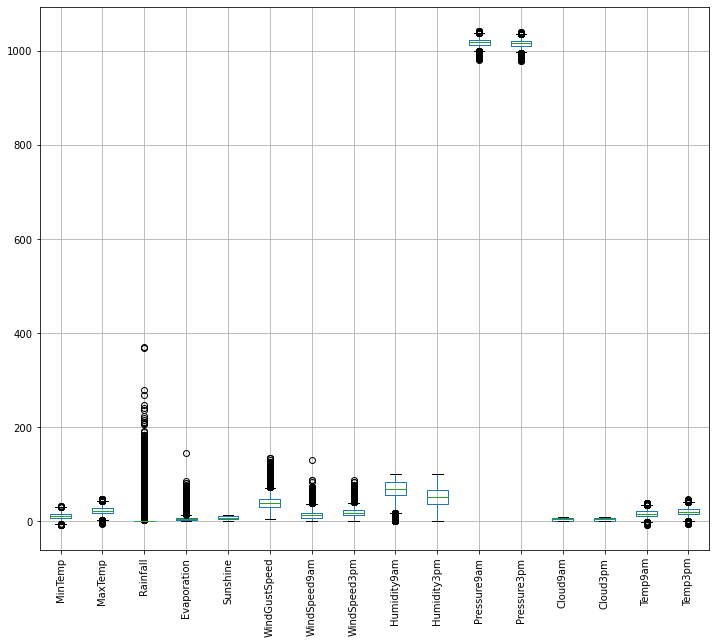

In [247]:
# for numerical, don't want to immediately impute something like the mean or mode for missing values
# need to first check for outliers
plt.figure(figsize=(12,10))
df.boxplot(only_num_null,rot = 90)

In [248]:
# there are indeed outliers (can see from the boxplot), which we will handle using the IQR method
# this is a drawback of filling in missing values because often outliers can tell us something important about the data
# for example, we have a lot of outliers for rainfall,which we are trying to predict, which means we might
# have trouble predicting rain for "outlying" events later on. 
# for loop to get rid of outliers
for feature in only_num_null:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature]<lower_limit, feature] = lower_limit
    df.loc[df[feature]>upper_limit, feature] = upper_limit

<AxesSubplot:>

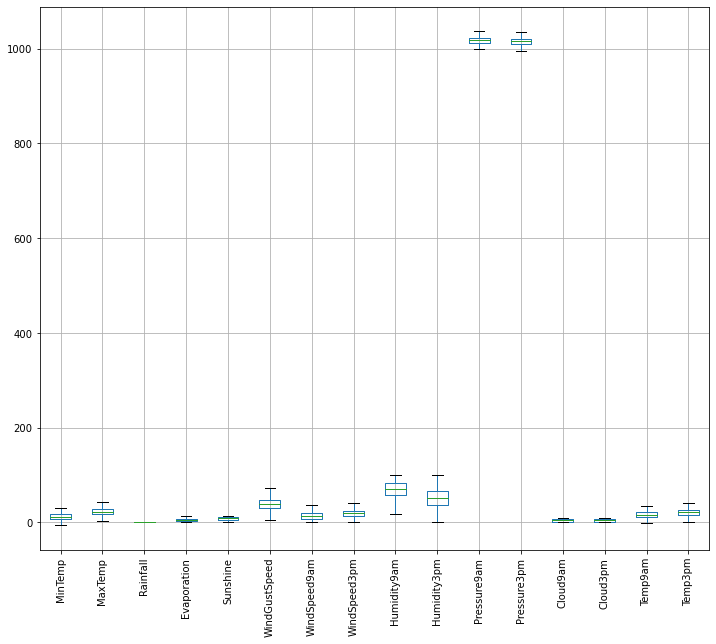

In [249]:
# now, we'll look at the boxplot again
plt.figure(figsize=(12,10))
df.boxplot(only_num_null,rot = 90) # we can see that there are no longer any outliers

In [250]:
# since we've gotten rid of outliers, we can now fill in missing cells with the mean 
for features in only_num_null:
    df[features] = df[features].fillna(df[features].mean())

# making sure that worked:
df[only_num_null].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

# Exploratory Data Analysis

We'll conduct some brief exploratory analysis before moving on. The most important thing to notice from these preliminary visualizations is the imbalance between "Yes" and "No" values for RainTomorrow. This will be important later on.

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

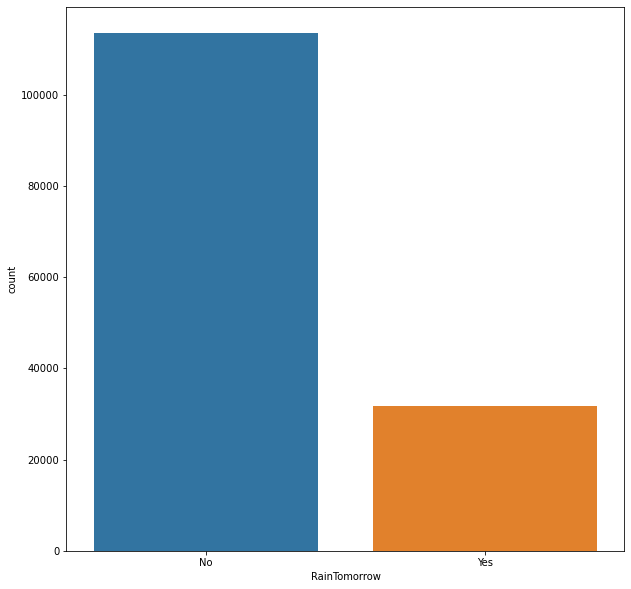

In [251]:
# first I"ll take a look at the target variable
sns.countplot(x = "RainTomorrow", data = df) 
# we can see that most days, it did not rain the next day
# in some cases it might be necessary to balance the data, but in this case it reflects reality
# (in australia, it is supposed to rain less days than it is not)

array([[<AxesSubplot:title={'center':'MinTemp'}>,
        <AxesSubplot:title={'center':'MaxTemp'}>,
        <AxesSubplot:title={'center':'Rainfall'}>,
        <AxesSubplot:title={'center':'Evaporation'}>],
       [<AxesSubplot:title={'center':'Sunshine'}>,
        <AxesSubplot:title={'center':'WindGustSpeed'}>,
        <AxesSubplot:title={'center':'WindSpeed9am'}>,
        <AxesSubplot:title={'center':'WindSpeed3pm'}>],
       [<AxesSubplot:title={'center':'Humidity9am'}>,
        <AxesSubplot:title={'center':'Humidity3pm'}>,
        <AxesSubplot:title={'center':'Pressure9am'}>,
        <AxesSubplot:title={'center':'Pressure3pm'}>],
       [<AxesSubplot:title={'center':'Cloud9am'}>,
        <AxesSubplot:title={'center':'Cloud3pm'}>,
        <AxesSubplot:title={'center':'Temp9am'}>,
        <AxesSubplot:title={'center':'Temp3pm'}>]], dtype=object)

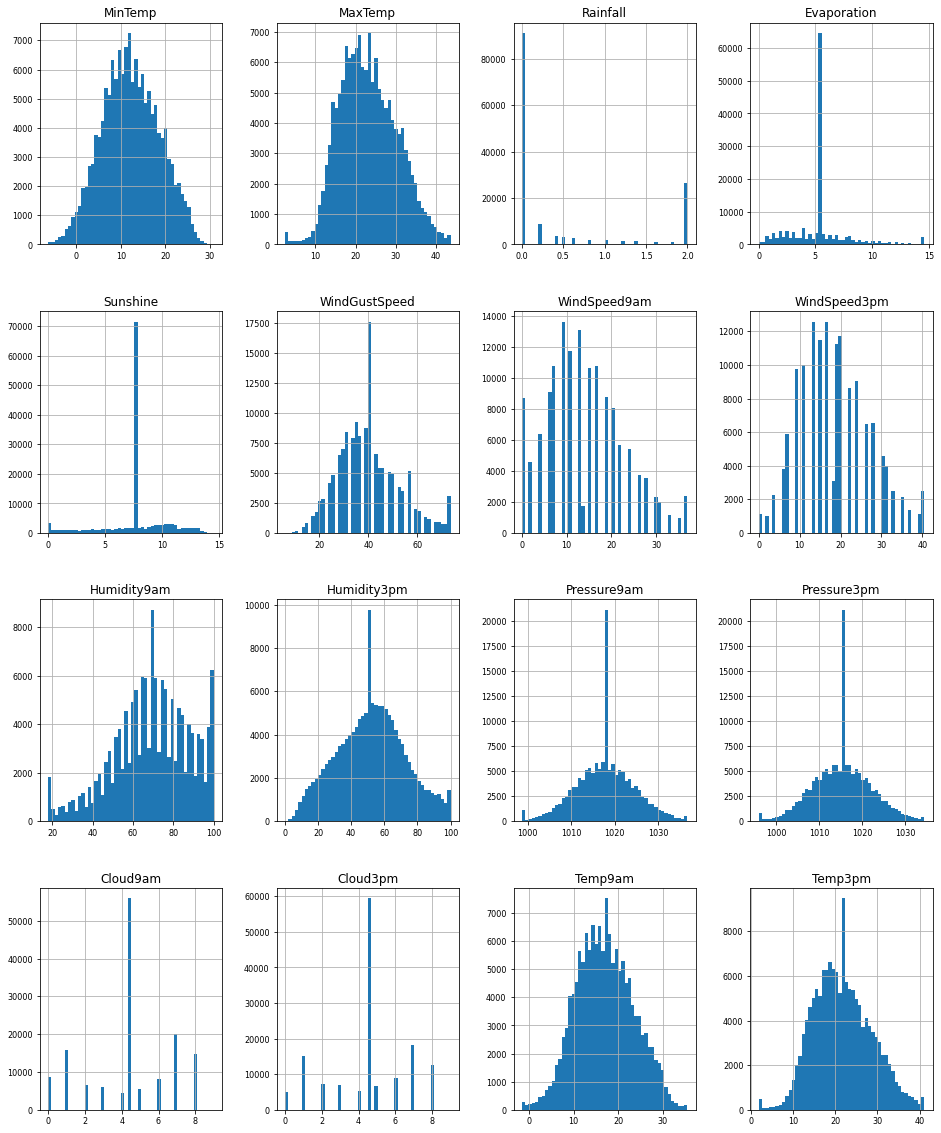

In [252]:
# make histograms for all numerical variables at once
df_num = df.select_dtypes(include = ['float64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

# Encoding

For our next step, we'll need to convert the categorical variables into a form that our Random Forest model will be able to understand. This is called encoding-- where we replace each categorical variable with numerical values. This will be done by creating a function that counts how many possible values each categorical variable has and then maps each qualitative value to it's corresponding unique index. The function then uses those numbers as the new 'qualitative' value.  

In [253]:
# we need to convert our categorical variables to something our model can understand

# getting final round up of categorical feautures
categorical = [i for i in df.columns if df[i].dtype == "O"]

categorical

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [254]:
# now to perform encoding, we'll make a function
def encoding(feature):
    mapping = {} 
    unique = list(df[feature].unique()) # getting unique qualitative values
    for index in range(len(unique)): 
        mapping[unique[index]] = index # converting to a numerical representation
    return mapping                     # of qualitative values

# applying the function to our data
for category in categorical:
    df[category].replace(encoding(category), inplace = True)
    
print(df.head()) # and this finishes our encoding

   Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0         0     13.4     22.9       0.6     5.318667  7.611178            0   
1         0      7.4     25.1       0.0     5.318667  7.611178            1   
2         0     12.9     25.7       0.0     5.318667  7.611178            2   
3         0      9.2     28.0       0.0     5.318667  7.611178            3   
4         0     17.5     32.3       1.0     5.318667  7.611178            0   

   WindGustSpeed  WindDir9am  WindDir3pm  ...  Pressure3pm  Cloud9am  \
0           44.0           0           0  ...       1007.1  8.000000   
1           44.0           1           1  ...       1007.8  4.447461   
2           46.0           0           1  ...       1008.7  4.447461   
3           24.0           2           2  ...       1012.8  4.447461   
4           41.0           3           3  ...       1006.0  7.000000   

   Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  year  month  day  
0   4.50993     1

# Data Preparation

Our last step before building the model is data preparation. We split the dataset and then apply SMOTE to our data because of the imbalance of "Yes" and "No" values in our target variable RainTomorrow.

SMOTE stands for Synthetic Minority Oversampling Technique. It's a statistical technique for increasing the number of cases in your data in a balanced way. This specific module works by generating new instances from existing minority cases that we supply as input. This module should be used for imbalanced datasets-- like ours!

In [255]:
y = df["RainTomorrow"]  # dependent or target 
X = df.drop(["RainTomorrow"],axis = 1)  # indepedent or input

In [256]:
# because our dataset is imbalanced (yes/no imbalance, more days it doesn't rain) will use SMOTE to balance data
smote_object = SMOTE()
# now creating x and y
X, y = smote_object.fit_resample(X, y)

In [257]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Random Forest Model

Finally, we build our Random Forest Model. Here we have the luxury of using 200 trees, which is one of the reasons our accuracy rate has a relatively high degree of correctness. However, the Random Forest Model can be slow in generating predictions due to the sheer number of decision trees. This is because whenever a prediction is made, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. 

For this specific report, that's totally fine, our dataset is small. But for large datasets that need to be processed quickly, a different algorithm or a smaller number of trees would need to be used.

In [258]:
# model
forest1 = RandomForestClassifier(n_estimators=400)

# training the model
forest1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400)

In [259]:
# predictions 
forest1_predictions = forest1.predict(X_test)

In [260]:
# check accuracy
print("Accuracy: " + str(metrics.accuracy_score(y_test, forest1_predictions)*100) +"%")

Accuracy: 90.48716067498165%


# Random Forest Feature Importance

What's nice about the Random Forest module from the sklearn package is the built in attribute "feature_importances_". We'll use this to investigate which features are most helpful in classification, and which are not. 

In [261]:
feature_importance = pd.Series(forest1.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_importance

Humidity3pm      0.146411
Rainfall         0.113794
Cloud3pm         0.076748
Sunshine         0.062733
Cloud9am         0.052166
WindGustSpeed    0.049780
Pressure3pm      0.048656
Humidity9am      0.046394
Pressure9am      0.041520
Temp3pm          0.032088
MinTemp          0.031683
MaxTemp          0.031010
Temp9am          0.029269
WindSpeed3pm     0.028659
Location         0.027197
WindSpeed9am     0.026085
day              0.023666
Evaporation      0.022507
WindGustDir      0.021620
WindDir3pm       0.020311
month            0.019960
WindDir9am       0.018715
year             0.018309
RainToday        0.010721
dtype: float64

No handles with labels found to put in legend.


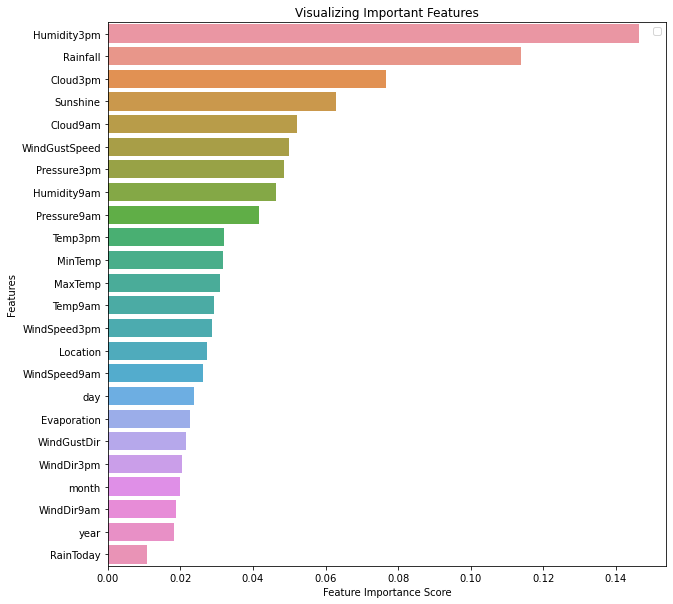

In [262]:
plt.rcParams["figure.figsize"] = (10, 10)
sns.barplot(x=feature_importance, y=feature_importance.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [263]:
#RainToday, year, and WindDir9am will be dropped because they're under 0.02
X = X.drop(["RainToday", "year", "WindDir9am"],axis = 1)

In [264]:
# split the updated data into train and test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Random Forest Model With Feature Selection

Next, we'll build a second Random Forest Model that only runs on the features deemed important once Feature Importance was analyzed. We can see that accuracy goes down from 90.5% to 90.4%. Thus we can conclude that while each feature has a differing level of helpfullness when it comes to determining whether it will rain tomorrow in Australia, it's still necessary to include ALL features in order to achieve the highest possible degree of accuracy.

In [265]:
# trying a model with 100 trees first
forest2 = RandomForestClassifier(n_estimators=400)

# training the model
forest2.fit(X_train_2, y_train_2)

RandomForestClassifier(n_estimators=400)

In [266]:
# predictions 
forest2_predictions = forest2.predict(X_test_2)

In [267]:
# check accuracy
print("Accuracy: " + str(metrics.accuracy_score(y_test_2, forest2_predictions)*100) +"%")
# accuracy went down -- can conclude that model is better with all of its features, 
# even the one with the lowest amount of feature importance

Accuracy: 90.44754218635363%
